A overview of the project:

- [ ] Step1: Generate order parameters maps and supercurrent maps.
- [ ] Step2: Construct machine learning model architecture
- [ ] Step3: Train the model
- [ ] Step4: Test the model

## Step1: Generate order parameters and super current maps

We consider the simplest model first:
\begin{equation}
   \hat{h} = \left( a k_x + i b k_y \right)^n \hat{\sigma}_+ + \left( a k_x - ib k_y \right)^n \hat{\sigma}_-
\end{equation}

In [1]:
%reload_ext autoreload
%autoreload 2
from google.colab import drive
drive.mount('/content/drive')
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_AI4Top/Top-invar-DL'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
import sys
sys.path.append(GOOGLE_DRIVE_PATH)
import torch
if torch.cuda.is_available:
  device = 'cuda'
  print('Good to go')
else:
  device = 'cpu'
  print('Please set GPU via Edit -> Notebook Settings')

Mounted at /content/drive
drive/My Drive/My_AI4Top/Top-invar-DL
Good to go


In [ ]:
import numpy as np
import pandas as pd
from Dirac_Current import *
import functools
import time

We use following expressions for computing the superfluid stiffness of above continuous model. The total superfluid stiffness is given by
\begin{equation}
     D_{xx} = 2 \Delta^2 \int^{\pi}_{-\pi} \frac{dk_x}{2 \pi} \frac{dk_y}{2 \pi} \sum_{\alpha,\beta} \frac{\left\vert \langle u_{\alpha} \left\vert \partial_{k_x} \hat{h} \right\vert u_{\beta} ⟩  \right\vert^2}{E^2_{\alpha} - E^2_{\beta}} \left[ \frac{f_\beta}{E_\beta} - \frac{f_\alpha}{E_\alpha} \right],
\end{equation}
which contain two components: the intra-band contribution

$$D_{\textrm{intra}} = \frac{a}{b} n \frac{\sqrt{\mu^2+\Delta^2}}{2\pi}\Bigg\{ \Theta(|\Delta|-|B|)+\Theta(|B|-|\Delta|)\Theta(\sqrt{\mu^2+\Delta^2}-|B|) \bigg[1-\frac{|\mu|}{\sqrt{\mu^2+\Delta^2}}\frac{|B|}{\sqrt{B^2-\Delta^2}}\bigg]\Bigg\}$$

and the inter-band contribution
$$D_{\textrm{inter}} = \frac{a}{b} n \frac{|\Delta|}{2\pi}\frac{|\Delta|}{|\mu|} \Bigg\{ \Theta(|\Delta|-|B|)\ln(\frac{\sqrt{\mu^2+\Delta^2}+|\mu|}{|\Delta|})+\Theta(|B|-|\Delta|)\Theta(\sqrt{\mu^2+\Delta^2}-|B|)\ln(\frac{\sqrt{\mu^2+\Delta^2}+|\mu|}{\sqrt{B^2-\Delta^2}+|B|}) \Bigg\}$$
when $\mu \to 0$, $D_{\textrm{inter}}=\frac{a}{b}n\frac{|\Delta|}{2\pi}\Theta(|\Delta|-|B|) $

where $ \left\vert \overline{k}  \right\vert = \sqrt{a^2 k_x^2 + b^2 k_y^2}   $, $ E_{\pm} = \sqrt{(\left\vert \overline{k}   \right\vert^n \pm \mu )^2 + \Delta^2}  $, $ f(E) = \Theta(B+E)-\Theta(B-E)  $

In [2]:
D_total_path = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_S.pt')
label_path = os.path.join(GOOGLE_DRIVE_PATH,'label_S.pt')
#D_total_path_l = os.path.join(GOOGLE_DRIVE_PATH,'D_total_tensor_l_S.pt')
#label_path_l = os.path.join(GOOGLE_DRIVE_PATH,'label_l_S.pt')
D_total = torch.load(D_total_path)
labels = torch.load(label_path)
#D_total_l = torch.load(D_total_path_l)
#labels_l = torch.load(label_path_l)
winding_u= D_total.shape[0]
mu_random = D_total.shape[1]
B_steps = D_total.shape[2]
mu_steps = D_total.shape[3]
#mu_random_l = D_total_l.shape[0]
print('D_total shape:',D_total.shape)
print('lables shape:',labels.shape)
print('D_total max:',D_total.max(),'D_total min:',D_total.min())
#print('D_total_1 shape:',D_total_l.shape)
#print('labels shape:',labels_l.shape)

D_total shape: torch.Size([10, 501, 15, 15])
lables shape: torch.Size([5010])
D_total max: tensor(1123.5634) D_total min: tensor(0.)


#### (Optional)Normalize the data

In [ ]:
# split dataset to training and unseen data
D_unseen = D_total[-2:].reshape(-1,1,mu_steps,B_steps) # the last two winding numbers as unseen data
D_train = D_total[:-2].reshape(-1,1,mu_steps,B_steps)
D_train_max = D_train.amax(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_train_min = D_train.amin(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_train = (D_train - D_train_min)/(D_train_max-D_train_min)
print(D_train.max(),D_train.min())
D_train = torch.cat((D_train,D_train_min,D_train_max),dim=1)

D_unseen_max = D_unseen.amax(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_unseen_min = D_unseen.amin(dim=(-2,-1),keepdim=True).repeat(1,1,mu_steps,B_steps)
D_unseen = (D_unseen - D_unseen_min)/(D_unseen_max-D_unseen_min)
print(D_unseen.max(),D_unseen.min())
D_unseen = torch.cat((D_unseen,D_unseen_min,D_unseen_max),dim=1)
print(f'D_train shape: {D_train.shape}')
print(f'D_unseen shape: {D_unseen.shape}')

tensor(1.) tensor(0.)
tensor(1.) tensor(0.)
D_train shape: torch.Size([4008, 3, 15, 15])
D_unseen shape: torch.Size([1002, 3, 15, 15])


## Set up dataset for training

In [47]:
# split dataset to training and unseen data
D_unseen = D_total[-2:].reshape(-1,1,mu_steps,B_steps) # the last two winding numbers as unseen data
D_train = D_total[:-2].reshape(-1,1,mu_steps,B_steps)

In [48]:
##############################################################
#set up dataset to train
##############################################################
from Superfluid_Neural_network_v2 import *
batch_size = 50
# set up labels 0-6 for training winding numbers, 7 for winding numbers above 6
labels[labels>6] = 7
labels = labels.long()
num_class = 8
#construct dataset
dataset = Superfluid_Dataset(D_train,labels[:(winding_u-2)*mu_random],train=True) # train the model with the train data
dataset_unseen = Superfluid_Dataset(D_unseen,labels[(winding_u-2)*mu_random:],train=True)

# split the dataset to train, validation, test
train_set, valid_set,test_set = torch.utils.data.random_split(dataset, [0.7,0.2,0.1])

#Using Dataloader for batch train
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)
test_loader_unseen = torch.utils.data.DataLoader(dataset=dataset_unseen,batch_size=batch_size,shuffle=True)

In [49]:
from Superfluid_Neural_network_v2 import *
CNN_stages = [(1,32,1),(32,2,1)]
fc_stages = [(CNN_stages[-1][1]*B_steps*mu_steps,1024,1),(1024,512,1)]
my_vgg = NN_net(CNN_stages,fc_stages,Plain_CNN_block,Plain_fc_block,num_classes=num_class)
#my_vgg.apply(weight_init)
print(my_vgg)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=450, out_features=1024, bias=True)
          (relu): ReLU()
        )
      )
    )
    (3): NN_stages(
      (net): Sequential(
        (0): Plain_fc_block(
          (fc): Linear(in_features=1024, out_features=512, bias=True)
          (relu): ReLU()
        )
      )
    )
    (4): Linear(in_features=512, out_features=8, bias=True)
  )
)


## Train the model

In [50]:
import random
from Training_loops import *
# optimizer parameters
epochs = 30
learning_rate_decay = .1
schedule = [10,25,40,45]
learning_rates = [1e-3]
weight_decays = [0]
acc_dict = {}
num_taskes = 2
for learning_rate in learning_rates:
  for weight_decay in weight_decays:
    my_vgg.apply(weight_init)
    L1_weight_decay = 0
    #awl = AutoWeightedLoss.AutoWeightedLoss(num_taskes)
    #optimizer = torch.optim.Adam([{'params':my_vgg.parameters()},{'params':awl.parameters(),'weight_decay':0,'lr':1e-4}],lr=learning_rate,weight_decay=weight_decay)
    optimizer = torch.optim.Adam([{'params':my_vgg.parameters()}],lr=learning_rate,weight_decay=weight_decay)

    acc_history,acc_val_history,loss_history,iter_history = train_part(model=my_vgg,optimizer=optimizer,
    train_loader=train_loader,valid_loader=valid_loader,epochs=epochs,learning_rate_decay=learning_rate_decay,schedule=schedule,weight_decay=L1_weight_decay,verbose=False)
    ##############################################################
    print('weight_decay: ',weight_decay)
    print('seen data acc: ')
    acc_test= check_accuary(test_loader,my_vgg)
    print('unseen data acc:')
    acc_test_unseen = check_accuary(test_loader_unseen,my_vgg)



Epoch 0, Iteration 57, loss = 0.2951
Got 564 / 802 correct 0.70
Got 1958 / 2806 correct 0.70

Epoch 1, Iteration 114, loss = 0.2051
Got 619 / 802 correct 0.77
Got 2202 / 2806 correct 0.78

Epoch 2, Iteration 171, loss = 0.1406
Got 678 / 802 correct 0.85
Got 2401 / 2806 correct 0.86

Epoch 3, Iteration 228, loss = 0.0062
Got 756 / 802 correct 0.94
Got 2662 / 2806 correct 0.95

Epoch 4, Iteration 285, loss = 0.0917
Got 760 / 802 correct 0.95
Got 2689 / 2806 correct 0.96

Epoch 5, Iteration 342, loss = 0.1996
Got 774 / 802 correct 0.97
Got 2727 / 2806 correct 0.97

Epoch 6, Iteration 399, loss = 0.0027
Got 796 / 802 correct 0.99
Got 2790 / 2806 correct 0.99

Epoch 7, Iteration 456, loss = 0.0007
Got 793 / 802 correct 0.99
Got 2791 / 2806 correct 0.99

Epoch 8, Iteration 513, loss = 0.0097
Got 790 / 802 correct 0.99
Got 2745 / 2806 correct 0.98

Epoch 9, Iteration 570, loss = 0.0036
Got 796 / 802 correct 0.99
Got 2791 / 2806 correct 0.99

Epoch 10, Iteration 627, loss = 0.0006
Got 796 / 80

In [ ]:
print("Model's state_dict: ")
for param_tensor in my_vgg.state_dict():
  print(param_tensor,"\t",my_vgg.state_dict()[param_tensor])


Model's state_dict: 
params 	 tensor([0.7687, 1.0139])


In [ ]:
my_vgg_path = os.path.join(GOOGLE_DRIVE_PATH,'my_vgg_path.pt')
torch.save(my_vgg.state_dict(),my_vgg_path)

In [ ]:
my_vgg_path = os.path.join(GOOGLE_DRIVE_PATH,'my_vgg_path.pt')
my_vgg.load_state_dict(torch.load(my_vgg_path))
my_vgg.eval()

Two_Branches_NN_net(
  (Conv_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (3): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
      )
    )
    (4): NN_stages(
      (net): Sequential(
        (0): Plain_CNN_block(
          (conv1): Conv2d(8, 1, kernel_size=(3

## Plot accuracy results

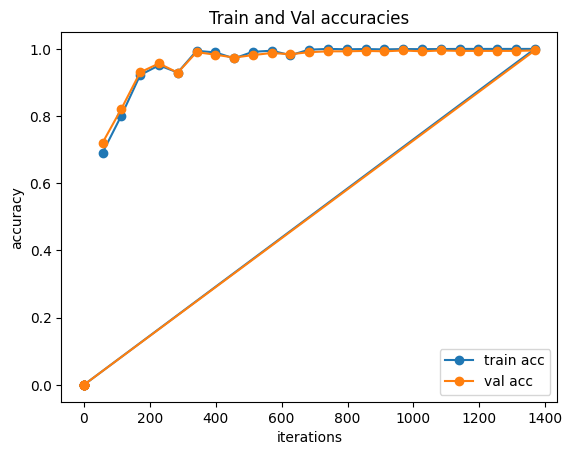

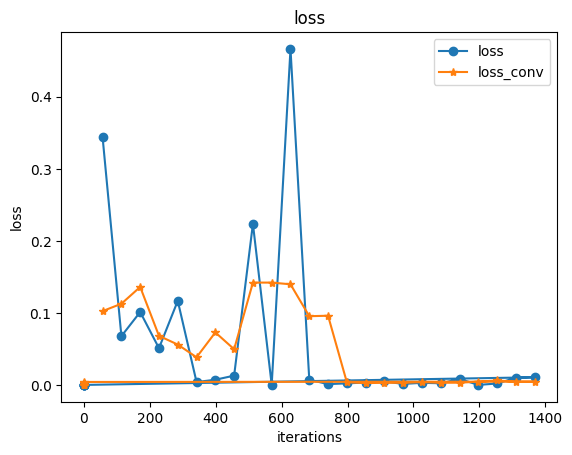

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val accuracies')
plt.plot(iter_history,acc_history,'-o')
plt.plot(iter_history,acc_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()
plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## Check acc with graphene data

In [51]:
Graphene_D_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_D.pt')
Graphene_label_path = os.path.join(GOOGLE_DRIVE_PATH,'Graphene_label.pt')
Graphene_D = torch.load(Graphene_D_path)
Graphene_labels = torch.load(Graphene_label_path)
# Graphene_D = Graphene_D.reshape(4,1,15,15)
# Graphene_labels = Graphene_labels.reshape(21,101)
# Graphene_D = Graphene_D[18,71:].reshape(-1,1,15,15)
# Graphene_labels = Graphene_labels[18,71:].reshape(-1)

In [52]:
print('max:',Graphene_D.max(),'min:',Graphene_D.min())

max: tensor(60.6531) min: tensor(-1.2738e-07)


In [53]:
from Training_loops import *
batch_size = 50
print(Graphene_D.shape)
Graphene_Data = Superfluid_Dataset(Graphene_D,Graphene_labels,train=True)
Graphene_loader = torch.utils.data.DataLoader(dataset=Graphene_Data,batch_size=batch_size,shuffle=True)
acc_Graphene= check_accuary(Graphene_loader,my_vgg,verbose=True)

torch.Size([121, 1, 15, 15])
Got 116 / 121 correct 0.96
Got 66 / 121 correct 0.55 preds as 0
Got 50 / 121 correct 0.41 preds as 2
Got 0 / 121 wrong 0.00 preds as 0
Got 0 / 121 wrong 0.00 preds as 1
Got 0 / 121 wrong 0.00 preds as 2
Got 5 / 121 wrong 0.04 preds as 3
Got 0 / 121 wrong 0.00 preds as 4
Got 0 / 121 wrong 0.00 preds as 5
Got 0 / 121 wrong 0.00 preds as 6
Got 0 / 121 wrong 0.00 preds as larger than 6


In [ ]:
my_vgg.to('cuda')
y = my_vgg(Graphene_D.to('cuda'))

In [ ]:
print(max(y[:,0]).item(),min(y[:,0]).item())

0.4833466410636902 -0.5748188495635986


In [ ]:
print(Graphene_labels[:,0])

tensor([1., 1., 1.,  ..., 1., 1., 1.])


# Fully connected neural network

In [ ]:
from Superfluid_Neural_network import *
#my_fc = threelayers_fc_block(in_neurals=B_steps,med_neurals=1024,out_neurals=1)
my_fc = torch.nn.Sequential(
    torch.nn.Linear(B_steps,512,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1024,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(1024,512,bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1,bias=True)
)
my_fc.apply(weight_init)

Sequential(
  (0): Linear(in_features=100, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=1, bias=True)
)

## Train fc

In [ ]:
import random
# optimizer parameters
epochs = 50
learning_rate_decay = .1
schedule = [10,25,40,45]
learning_rates = [1e-2]
weight_decays = [0]
hyper_n = 16
acc_dict = {}
for learning_rate in learning_rates:
  for weight_decay in weight_decays:
    my_fc.apply(weight_init)
    #learning_rate = random.uniform(learning_rate_min,learning_rate_max)
    #weight_decay = random.uniform(weight_decay_min,weight_decay_max)
    L1_weight_decay = 0
    optimizer = torch.optim.Adam(my_fc.parameters(),lr=learning_rate,weight_decay=weight_decay)
    acc_history,acc_val_history,loss_history,iter_history = train_part(model=my_fc,optimizer=optimizer,train_loader=train_loader,valid_loader=valid_loader,epochs=epochs,learning_rate_decay=learning_rate_decay,schedule=schedule,weight_decay=L1_weight_decay,verbose=False)
    ##############################################################
    acc_test = check_accuary(test_loader,my_fc)
    acc_test_11 = check_accuary(test_loader_unseen_11,my_fc)
    acc_test_12 = check_accuary(test_loader_unseen_12,my_fc)
    acc_test_20 = check_accuary(test_loader_unseen_20_val,my_fc)
    acc_test_l = check_accuary(test_loader_unseen_l,my_fc)
    acc_test_l_20 = check_accuary(test_loader_unseen_l_20,my_fc)
    acc_dict.setdefault(f'lr: {learning_rate:.1e}, l2: {weight_decay:.1e}',[]).append(f'test data set acc: {acc_test:.3f}, unseen acc(w=11): {acc_test_11}, unseen acc(w=12): {acc_test_12},unseen acc(w=20): {acc_test_20}, unseen acc(mu>10):{acc_test_l}, unseen acc(mu>10,w=20): {acc_test_l_20}')



Epoch 0, Iteration 154, loss = 0.0978
Got 1985 / 2200 correct 0.90
Got 6899 / 7700 correct 0.90

Epoch 1, Iteration 308, loss = 0.1380
Got 1892 / 2200 correct 0.86
Got 6627 / 7700 correct 0.86

Epoch 2, Iteration 462, loss = 0.0545
Got 2081 / 2200 correct 0.95
Got 7237 / 7700 correct 0.94

Epoch 3, Iteration 616, loss = 0.0547
Got 2053 / 2200 correct 0.93
Got 7240 / 7700 correct 0.94

Epoch 4, Iteration 770, loss = 0.0335
Got 1815 / 2200 correct 0.82
Got 6533 / 7700 correct 0.85

Epoch 5, Iteration 924, loss = 0.0454
Got 1940 / 2200 correct 0.88
Got 6843 / 7700 correct 0.89

Epoch 6, Iteration 1078, loss = 0.0489
Got 2086 / 2200 correct 0.95
Got 7308 / 7700 correct 0.95

Epoch 7, Iteration 1232, loss = 0.0993
Got 2123 / 2200 correct 0.96
Got 7385 / 7700 correct 0.96

Epoch 8, Iteration 1386, loss = 0.1066
Got 2151 / 2200 correct 0.98
Got 7518 / 7700 correct 0.98

Epoch 9, Iteration 1540, loss = 0.0232
Got 2160 / 2200 correct 0.98
Got 7574 / 7700 correct 0.98

Epoch 10, Iteration 1694, 

In [ ]:
print(acc_dict)

{'lr: 1.0e-02, l2: 0.0e+00': ['test data set acc: 0.995, unseen acc(w=11): 0.971, unseen acc(w=12): 0.956']}


# ResNet model

In [ ]:
from Superfluid_Neural_network import *
ResNet_stages = [(4,4,3),]
my_ResNet = ResNet(ResNet_stages,x_Cin=1,x_length=B_steps,fc_neural=8,block=ResidualBottleneckBlock_1d,num_classes=1) #one-dim ResNet
my_ResNet.apply(weight_init)

ResNet(
  (net): Sequential(
    (0): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock_1d(
          (block): Sequential(
            (0): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): LeakyReLU(negative_slope=0.01)
            (2): Conv1d(4, 1, kernel_size=(1,), stride=(1,))
            (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (4): LeakyReLU(negative_slope=0.01)
            (5): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
            (6): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (7): LeakyReLU(negative_slope=0.01)
            (8): Conv1d(1, 4, kernel_size=(1,), stride=(1,))
          )
          (shortcut): Identity()
        )
        (1): ResidualBottleneckBlock_1d(
          (block): Sequential(
            (

## Train ResNet

In [ ]:
import random
# optimizer parameters
epochs = 50
learning_rate_decay = .1
schedule = [10,25,40,45]
learning_rates = [1e-2]
weight_decays = [0]
acc_dict = {}
for learning_rate in learning_rates:
  for weight_decay in weight_decays:
    my_ResNet.apply(weight_init)
    #learning_rate = random.uniform(learning_rate_min,learning_rate_max)
    #weight_decay = random.uniform(weight_decay_min,weight_decay_max)
    L1_weight_decay = 0
    optimizer = torch.optim.Adam(my_ResNet.parameters(),lr=learning_rate,weight_decay=weight_decay)
    acc_history,acc_val_history,loss_history,iter_history = train_part(model=my_ResNet,optimizer=optimizer,train_loader=train_loader,valid_loader=valid_loader,epochs=epochs,learning_rate_decay=learning_rate_decay,schedule=schedule,weight_decay=L1_weight_decay,verbose=False)
    ##############################################################
    acc_test = check_accuary(test_loader,my_ResNet)
    acc_test_11 = check_accuary(test_loader_unseen_11,my_ResNet)
    acc_test_12 = check_accuary(test_loader_unseen_12,my_ResNet)
    acc_dict.setdefault(f'lr: {learning_rate:.1e}, l2: {weight_decay:.1e}',[]).append(f'test data set acc: {acc_test:.3f}, unseen acc(w=11): {acc_test_11}, unseen acc(w=12): {acc_test_12}')

Epoch 0, Iteration 154, loss = 0.4398
Got 1763 / 2200 correct 0.80
Got 6181 / 7700 correct 0.80

Epoch 1, Iteration 308, loss = 1.3672
Got 1749 / 2200 correct 0.80
Got 6101 / 7700 correct 0.79

Epoch 2, Iteration 462, loss = 0.3263
Got 1946 / 2200 correct 0.88
Got 6889 / 7700 correct 0.89

Epoch 3, Iteration 616, loss = 0.2084
Got 1980 / 2200 correct 0.90
Got 7024 / 7700 correct 0.91

Epoch 4, Iteration 770, loss = 0.3626
Got 1297 / 2200 correct 0.59
Got 4580 / 7700 correct 0.59

Epoch 5, Iteration 924, loss = 0.1107
Got 1876 / 2200 correct 0.85
Got 6528 / 7700 correct 0.85

Epoch 6, Iteration 1078, loss = 0.2320
Got 1581 / 2200 correct 0.72
Got 5626 / 7700 correct 0.73

Epoch 7, Iteration 1232, loss = 0.1230
Got 1393 / 2200 correct 0.63
Got 5073 / 7700 correct 0.66

Epoch 8, Iteration 1386, loss = 0.1042
Got 2043 / 2200 correct 0.93
Got 7131 / 7700 correct 0.93

Epoch 9, Iteration 1540, loss = 0.0708
Got 2062 / 2200 correct 0.94
Got 7294 / 7700 correct 0.95

lr decay from 0.01 to 0.00

In [ ]:
print(acc_dict)

{'lr: 1.0e-02, l2: 9.0e-02': ['test data set acc: 0.934, unseen acc(w=11): 0.664, unseen acc(w=12): 0.568'], 'lr: 1.0e-02, l2: 1.0e-03': ['test data set acc: 0.993, unseen acc(w=11): 0.928, unseen acc(w=12): 0.809'], 'lr: 1.0e-02, l2: 3.0e-03': ['test data set acc: 0.965, unseen acc(w=11): 0.812, unseen acc(w=12): 0.769']}


## Plot accuracy result

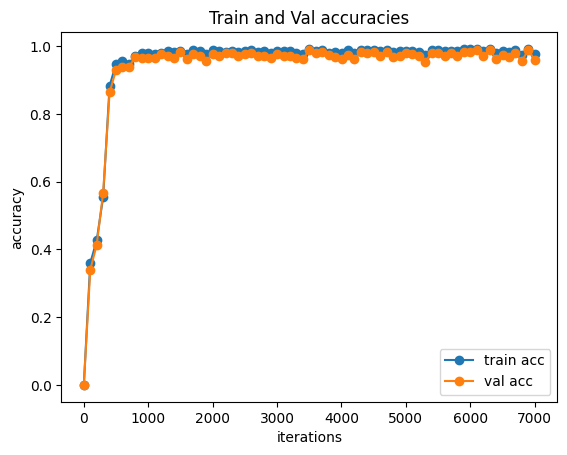

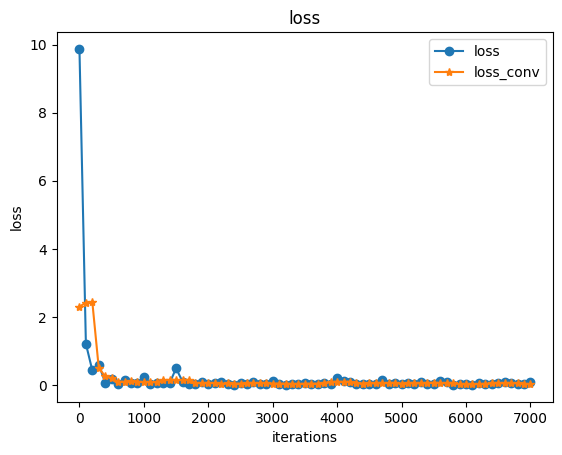

In [ ]:
import matplotlib.pyplot as plt
ave_site = 5
ave_kernel = 1/ave_site*np.ones(ave_site)
loss_history_conv = np.convolve(loss_history.numpy(),ave_kernel,'same')
plt.title('Train and Val accuracies')
plt.plot(iter_history,acc_history,'-o')
plt.plot(iter_history,acc_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()
plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.plot(iter_history,loss_history_conv,'-*')
plt.legend(['loss','loss_conv'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()

## Check acc with test data

In [ ]:
acc_test = check_accuary(test_loader,my_ResNet)
print(f'test data set accuracy: {acc_test}')

Got 385 / 400 correct 0.96
test data set accuracy: 0.9625


In [ ]:
from Superfluid_Neural_network import *
Conv_args = [(1,4,1),(4,4,2)]
fc_args = [(100,64,1),(64,64,2),(64,1,1)]
my_test_model = NN_net(Conv_args,fc_args,Onelayers_CNN_block,onelayers_fc_block,1)
print(my_test_model)

NN_net(
  (total_net): Sequential(
    (0): NN_stages(
      (net): Sequential(
        (0): Onelayers_CNN_block(
          (conv1): Conv1d(1, 4, kernel_size=(3,), stride=(1,), padding=(1,))
          (relu): ReLU()
        )
      )
    )
    (1): NN_stages(
      (net): Sequential(
        (0): Onelayers_CNN_block(
          (conv1): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
          (relu): ReLU()
        )
        (1): Onelayers_CNN_block(
          (conv1): Conv1d(4, 4, kernel_size=(3,), stride=(1,), padding=(1,))
          (relu): ReLU()
        )
      )
    )
    (2): NN_stages(
      (net): Sequential(
        (0): onelayers_fc_block(
          (fc): Linear(in_features=100, out_features=64, bias=True)
        )
      )
    )
    (3): NN_stages(
      (net): Sequential(
        (0): onelayers_fc_block(
          (fc): Linear(in_features=64, out_features=64, bias=True)
        )
        (1): onelayers_fc_block(
          (fc): Linear(in_features=64, out_features

## Test my code to Hamiltonian task

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
def history_figure(history):
    acc = history.history['mae']
    loss = history.history['loss']
    val_acc = history.history['val_mae']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs,acc,'b',label = 'Training_mae' )
    plt.plot(epochs,val_acc,'r',label='Validation_mae')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'b',label = 'Training_loss' )
    plt.plot(epochs,val_loss,'r',label='Validation_loss')
    plt.legend()
    plt.show()
c_train = 3
c = 0
N = 700000
L = 32

def cos_sin_Matrix_Generator(c,k,L=L):
    #this function generate [cos(nk),sin(nk)] matrix
    Z_cos = np.zeros((c,L+1))
    Z_sin = np.zeros((c,L+1))
    for i in range(c):
        Z_cos[i,:] = np.cos( (i+1)*k)
        Z_sin[i,:] = np.sin( (i+1)*k)
    cos_sin_matrix = np.vstack((Z_cos,Z_sin))
    return cos_sin_matrix
#print(cos_sin_Matrix_Generator(c,np.linspace(0,2*np.pi,L+1)))
def winding_number_Marker(d):
    d = d[0,:] + 1j*d[1,:]
    theta = (np.angle(d)  )  #calculate theta function in the paper
    theta_1 = np.roll(theta,1) #left shift one position
    Delta_theta = (theta-theta_1)
    Delta_theta[Delta_theta<-np.pi] += 2*np.pi
    Delta_theta[Delta_theta>np.pi] -= 2*np.pi #constrain the angle to [-pi,pi]
    #Delta_theta = np.copysign(Delta_theta%(2*np.pi),Delta_theta)
    w = np.round(-1/(2*np.pi) * np.sum(Delta_theta[1:]),decimals=10)
    return w





def Input_Data_Generator(c, L=L):
    # arg: c the number of maximum of possible winding number
    # arg: L the number of discretized points in k space
    # arg: N the number of samples
    # uniform sampling coefficients
    C_matrix = np.random.uniform(-1,1,size=(2,2*c))
    k = np.linspace(0,2*np.pi,L+1)
    d = np.dot(C_matrix,cos_sin_Matrix_Generator(c,k))
    d_abs = np.linalg.norm(d,axis=0)
    d = d/d_abs
    w = winding_number_Marker(d)
    return d_abs,d,w

def balance_sample(X_train,Y_train):
    winding_class = np.unique(Y_train)
    Total_num = Y_train.shape[0]
    frac_num = np.round(Total_num/winding_class.shape[0])
    frac_num=frac_num.astype(int)
    X_train_keep = np.zeros_like(X_train,dtype=float)
    Y_train_keep = np.zeros_like(Y_train,dtype=float)
    j = 0
    for i in winding_class:
        j = j+1
        mask = np.random.choice(np.argwhere(Y_train==i).flatten(),frac_num)
        X_train_keep[frac_num*(j-1):frac_num*j] = X_train[mask]
        Y_train_keep[frac_num*(j-1):frac_num*j] = np.ones(frac_num)*i
    return X_train_keep, Y_train_keep



X_train = []
Y_train =[]
for i in range(N):
    Input_Data = Input_Data_Generator(c_train)
    if np.all(Input_Data[0]):
        X_train.append(Input_Data[1])
        Y_train.append(Input_Data[2]+c)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_train,Y_train = balance_sample(X_train,Y_train)
Y_train = np.expand_dims(Y_train,axis=1)
unique,counts = np.unique(Y_train,return_counts=True)
print(f'Input features data has dimension: {X_train.shape}')
print(f'Input labels data has dimension: {Y_train.shape}')
print(f'for each winding number the data set contains {np.asarray((unique,counts)).T}')

KeyboardInterrupt: ignored

In [ ]:
Data_x = torch.from_numpy(np.float32(X_train)).reshape(N,1,2,L+1)
Data_y = torch.from_numpy(Y_train).reshape(N)
Data_x_path = os.path.join(GOOGLE_DRIVE_PATH,'Hamiltonian.pt')
Data_y_path = os.path.join(GOOGLE_DRIVE_PATH,'winding_label.pt')
torch.save(Data_x,Data_x_path)
torch.save(Data_y,Data_y_path)

NameError: ignored

In [ ]:
Data_x_path = os.path.join(GOOGLE_DRIVE_PATH,'Hamiltonian.pt')
Data_y_path = os.path.join(GOOGLE_DRIVE_PATH,'winding_label.pt')
Data_x = torch.load(Data_x_path)
Data_y = torch.load(Data_y_path)

In [ ]:
##############################################################
#set up dataset to train
##############################################################
from Superfluid_Neural_network import *
batch_size = 30

#construct dataset
H_dataset = Superfluid_Dataset(Data_x,Data_y,train=True)
# split the dataset to train, validation, test
train_set, valid_set, test_set = torch.utils.data.random_split(H_dataset, [0.7,0.2,0.1])
test_set.train = False
#Using Dataloader for batch train
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [ ]:
#####################################################################
# construct network
#####################################################################
from Superfluid_Neural_network import *
h_stages = [(1,40),(40,1)]
H_model = H_CNN(h_stages,in_width=32,fc_neural=2,num_class=1)
print(H_model)

H_CNN(
  (cnn): Sequential(
    (0): Onelayers_CNN_block_1(
      (conv1): Conv2d(1, 40, kernel_size=(2, 2), stride=(1, 1))
    )
    (1): Onelayers_CNN_block_2(
      (conv1): Conv2d(40, 1, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): threelayers_fc_block(
      (fc): Linear(in_features=32, out_features=2, bias=True)
      (fc1): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)


### Train

In [ ]:
# optimizer parameters
learning_rate = 1e-3
weight_decay = 0*1e-4
epochs = 1
learning_rate_decay = .1
schedule = [6,15]
#model = ThreeLayers_CNN(in_channel,channel_1,channel_2,channel_out)
model = H_model
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
acc_history,acc_val_history,loss_history,iter_history = train_part(model,optimizer,test_loader,valid_loader,epochs,learning_rate_decay,schedule,True)

Epoch 0, Iteration 1, loss = 4.6768
Got 20009 / 140000 correct 0.14
Got 9856 / 70000 correct 0.14

Epoch 0, Iteration 101, loss = 1.3507
Got 28253 / 140000 correct 0.20
Got 14192 / 70000 correct 0.20

Epoch 0, Iteration 201, loss = 1.4109
Got 57398 / 140000 correct 0.41
Got 28606 / 70000 correct 0.41

Epoch 0, Iteration 301, loss = 1.2926
Got 68800 / 140000 correct 0.49
Got 34366 / 70000 correct 0.49

Epoch 0, Iteration 401, loss = 0.6883
Got 73801 / 140000 correct 0.53
Got 36844 / 70000 correct 0.53

Epoch 0, Iteration 501, loss = 0.7515
Got 77756 / 140000 correct 0.56
Got 38752 / 70000 correct 0.55

Epoch 0, Iteration 601, loss = 0.6972
Got 80713 / 140000 correct 0.58
Got 40277 / 70000 correct 0.58

Epoch 0, Iteration 701, loss = 0.7135
Got 82573 / 140000 correct 0.59
Got 41210 / 70000 correct 0.59

Epoch 0, Iteration 801, loss = 0.5165
Got 84536 / 140000 correct 0.60
Got 42244 / 70000 correct 0.60

Epoch 0, Iteration 901, loss = 0.4076
Got 85900 / 140000 correct 0.61
Got 42898 / 700

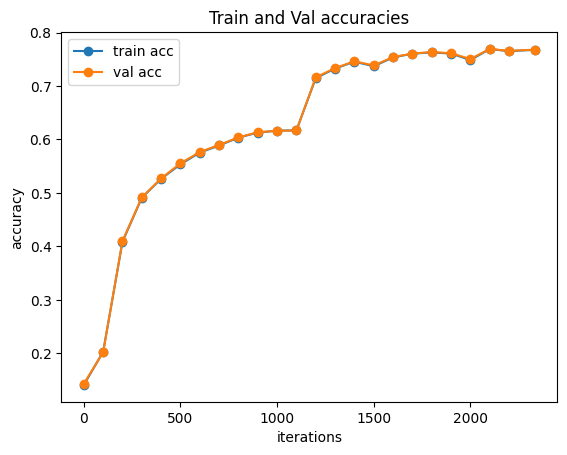

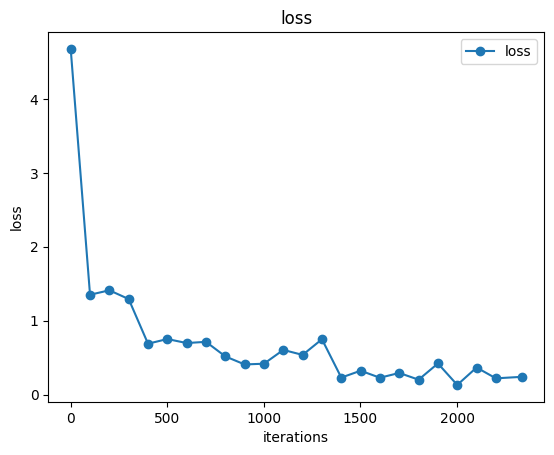

In [ ]:
import matplotlib.pyplot as plt
plt.title('Train and Val accuracies')
plt.plot(iter_history,acc_history,'-o')
plt.plot(iter_history,acc_val_history,'-o')
plt.legend(['train acc','val acc'])
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()
plt.title('loss')
plt.plot(iter_history,loss_history,'-o')
plt.legend(['loss'])
plt.xlabel('iterations')
plt.ylabel('loss')
plt.show()